In [ ]:
import pandas as pd
import requests
from datetime import datetime
from google.colab import files

# --- Config ---
CITY = "Chennai"
LAT, LON = 13.0827, 80.2707
START_DATE = "2024-01-01"
END_DATE = "2025-01-31"
OUTPUT_FILE = "chennai_weather_aqi_2024_2025.csv"

# --- Fetch Weather Data ---
def fetch_weather_data(lat, lon, start_date, end_date):
    print("📦 Fetching weather data...")
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_min,temperature_2m_max,relative_humidity_2m_mean",
        "timezone": "Asia/Kolkata"
    }
    r = requests.get(url, params=params)
    data = r.json()

    if "daily" not in data:
        raise ValueError("❌ Weather data not found!")

    df = pd.DataFrame({
        "date": pd.to_datetime(data["daily"]["time"]).strftime("%d-%m-%Y"),
        "temp_min": data["daily"]["temperature_2m_min"],
        "temp_max": data["daily"]["temperature_2m_max"],
        "humidity_mean": data["daily"]["relative_humidity_2m_mean"]
    })
    return df

# --- Generate Dummy AQI Data ---
def generate_dummy_aqi(start_date, end_date):
    print("📦 Generating dummy AQI data...")
    dates = pd.date_range(start=start_date, end=end_date, freq="D")
    dummy_pm25 = [round(40 + (i % 10) * 2.5, 1) for i in range(len(dates))]
    df = pd.DataFrame({
        "date": dates.strftime("%d-%m-%Y"),
        "pm25": dummy_pm25
    })
    return df

# --- Combine and Save ---
weather_df = fetch_weather_data(LAT, LON, START_DATE, END_DATE)
aqi_df = generate_dummy_aqi(START_DATE, END_DATE)

print("🔁 Merging weather and AQI data...")
final_df = pd.merge(weather_df, aqi_df, on="date", how="left")

# Reorder columns
final_df = final_df[["date", "temp_min", "temp_max", "humidity_mean", "pm25"]]

# Save to CSV
final_df.to_csv(OUTPUT_FILE, index=False)
print(f"✅ File saved as {OUTPUT_FILE}")

# Download
files.download(OUTPUT_FILE)

📦 Fetching weather data...
📦 Generating dummy AQI data...
🔁 Merging weather and AQI data...
✅ File saved as chennai_weather_aqi_2024_2025.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Upload your CSV file (chennai_weather_aqi_2024_2025.csv)
uploaded = files.upload()


Saving chennai_weather_aqi_2024_2025.csv to chennai_weather_aqi_2024_2025 (1).csv


In [ ]:
import pandas as pd

# Load the uploaded CSV file
df = pd.read_csv("chennai_weather_aqi_2024_2025.csv")

# Display the first few rows to confirm
df.head()


,date,temp_min,temp_max,humidity_mean,pm25
0,01-01-2024,22.8,28.7,71,40.0
1,02-01-2024,22.9,27.8,70,42.5
2,03-01-2024,23.6,28.2,69,45.0
3,04-01-2024,24.7,29.0,71,47.5
4,05-01-2024,24.4,29.0,71,50.0


In [ ]:
# Ensure numeric values and handle any missing data
df['temp_min'] = pd.to_numeric(df['temp_min'], errors='coerce')
df['temp_max'] = pd.to_numeric(df['temp_max'], errors='coerce')
df['humidity_mean'] = pd.to_numeric(df['humidity_mean'], errors='coerce')
df['pm25'] = pd.to_numeric(df['pm25'], errors='coerce')

# Drop rows with any missing values
df.dropna(inplace=True)


In [ ]:
# Features (inputs) and Target (output)
X = df[['temp_min', 'temp_max', 'humidity_mean']]  # Inputs
y = df['pm25']                                      # Output (PM2.5)


In [ ]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Create and train the model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test)

# Show evaluation metrics
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


Mean Squared Error: 99.6875
R² Score: -1.0521067867481504


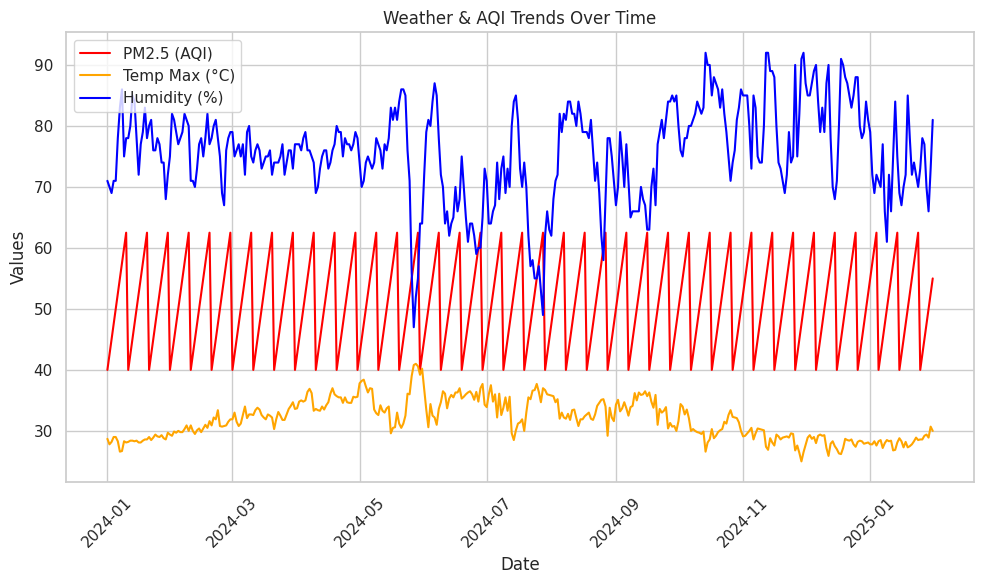

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Make plots look nicer
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# --- 1. Trend over Time (AQI, Temp Max, Humidity) ---
df_plot = df.copy()
df_plot['date'] = pd.to_datetime(df_plot['date'], dayfirst=True)

plt.plot(df_plot['date'], df_plot['pm25'], label='PM2.5 (AQI)', color='red')
plt.plot(df_plot['date'], df_plot['temp_max'], label='Temp Max (°C)', color='orange')
plt.plot(df_plot['date'], df_plot['humidity_mean'], label='Humidity (%)', color='blue')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Weather & AQI Trends Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


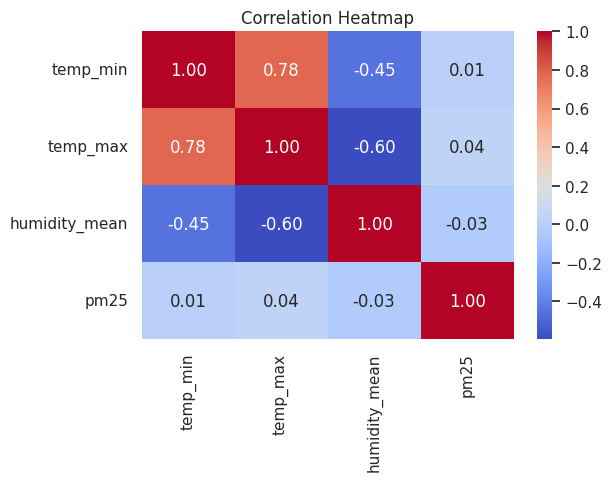

In [ ]:
# --- 2. Correlation Heatmap ---
plt.figure(figsize=(6, 4))
corr = df[['temp_min', 'temp_max', 'humidity_mean', 'pm25']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


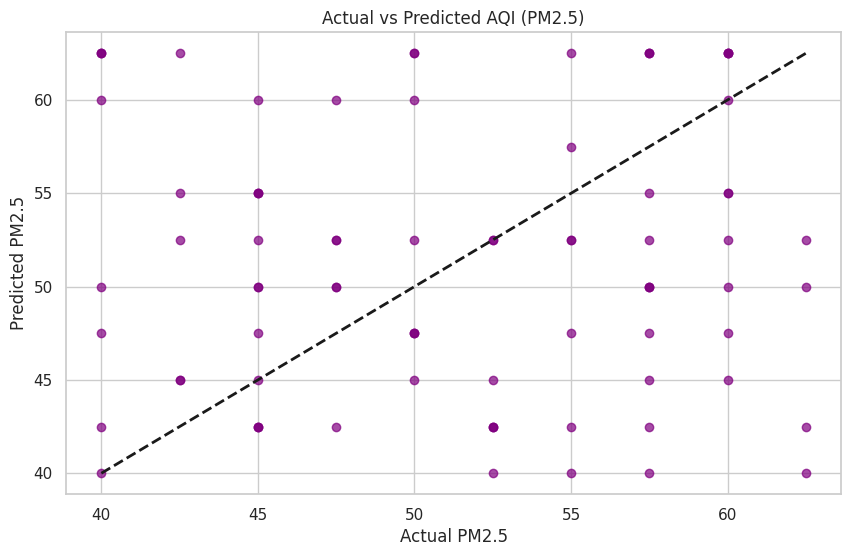

In [ ]:
# --- 3. Actual vs Predicted AQI ---
plt.scatter(y_test, y_pred, alpha=0.7, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted AQI (PM2.5)')
plt.grid(True)
plt.show()


<ipython-input-13-fd44c0f4a89d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette="viridis")


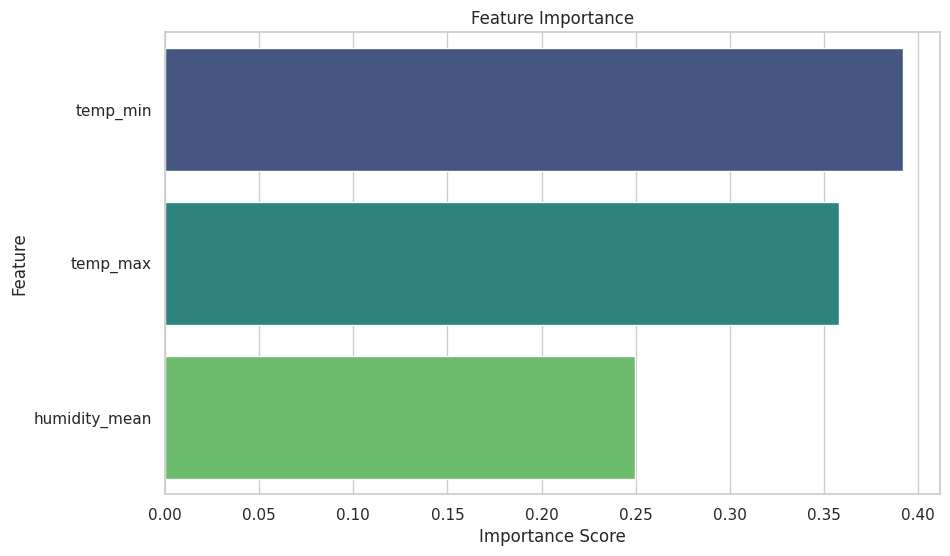

In [ ]:
# --- 4. Feature Importance ---
import numpy as np

importance = model.feature_importances_
features = X.columns
sns.barplot(x=importance, y=features, palette="viridis")
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


In [ ]:
from joblib import dump
from google.colab import files

# Save the model
dump(model, 'air_quality_model.joblib')

# Download the model file
files.download('air_quality_model.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>